<a href="https://colab.research.google.com/github/royseto/langgraph-tutorials-royseto/blob/main/LangGraph_Multiply_Tool_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab notebook has Roy's work with the LangGraph Quickstart at https://langchain-ai.github.io/langgraph/tutorials/introduction/

# Setup

In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

In [ ]:
"""
The LangGraph Quickstart gets API keys interactively using `getpass`.
On colab, get them from colab secrets instead. Commenting this out.

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
"""

'\nThe LangGraph Quickstart gets API keys interactively using `getpass`.\nOn colab, get them from colab secrets instead. Commenting this out.\n\nimport getpass\nimport os\n\n\ndef _set_env(var: str):\n    if not os.environ.get(var):\n        os.environ[var] = getpass.getpass(f"{var}: ")\n\n\n_set_env("ANTHROPIC_API_KEY")\n'

In [4]:
import os
from google.colab import userdata

os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-quickstart"

# Part 1: Build a Basic Chatbot

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
from langchain_anthropic import ChatAnthropic

#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [7]:
graph_builder.add_edge(START, "chatbot")

In [8]:
graph_builder.add_edge("chatbot", END)

In [9]:
graph = graph_builder.compile()

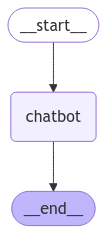

In [10]:
graph

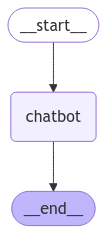

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what is 2 * 3
Assistant: 2 * 3 = 6
User: quit
Goodbye!


# Multiply tool

- https://python.langchain.com/docs/how_to/custom_tools/
- https://python.langchain.com/docs/how_to/tool_calling/

In [13]:
from langchain_core.tools import tool


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two numbers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [14]:
tools = [multiply]

In [15]:
tools[0].invoke("what is 2 * 3?")

ValidationError: 2 validation errors for multiply
a
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='what is 2 * 3?', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/int_parsing
b
  Field required [type=missing, input_value={'a': 'what is 2 * 3?'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [16]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("claude-3-5-sonnet-latest", model_provider="anthropic")

In [17]:
llm_with_tools = llm.bind_tools(tools)

query = "What is 3 * 12?"

llm_with_tools.invoke(query)

AIMessage(content=[{'text': "I'll help you multiply 3 and 12 using the multiply function.", 'type': 'text'}, {'id': 'toolu_01QjQAwoNMmbjndy9kvV5bJm', 'input': {'a': 3, 'b': 12}, 'name': 'multiply', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_018AUN39zHtkeLQ1CsUPR8j5', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 392, 'output_tokens': 86}}, id='run-fe11a924-9266-4317-b9d0-4b915d435b91-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'toolu_01QjQAwoNMmbjndy9kvV5bJm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 392, 'output_tokens': 86, 'total_tokens': 478, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})